In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from statsmodels.tsa.holtwinters import ExponentialSmoothing

sys.path.append("..")
from utils import create_onedrive_directdownload

plt.style.use("fivethirtyeight")

In [2]:
onedrive_link  = "https://1drv.ms/u/s!AiqdXCxPTydhoogqfj86CvQcSInxtA?e=mdfJYY"
converted_link = create_onedrive_directdownload(onedrive_link)
df = pd.read_csv(converted_link, index_col="Date", parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [3]:
goog = df[df["Name"] == "GOOG"][["Close"]].copy()

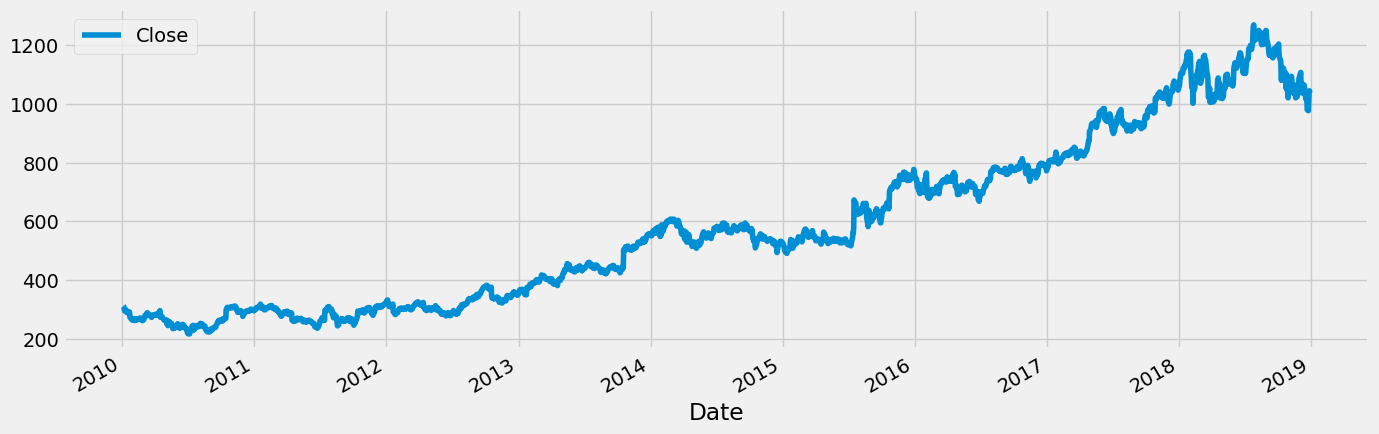

In [6]:
goog.plot(figsize=(15, 5));

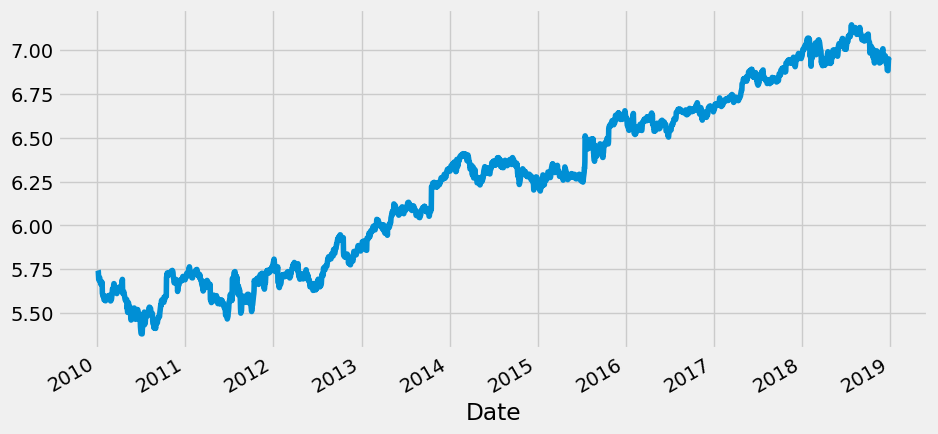

In [7]:
goog["LogClose"] = np.log(goog["Close"])

goog["LogClose"].plot(figsize=(10,5));

In [ ]:
# goog.index.freq = "B"

In [8]:
Ntest = 30
train = goog.iloc[:-Ntest]
test  = goog.iloc[-Ntest:]

In [10]:
# boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx  = goog.index > train.index[-1]

In [11]:
hw = ExponentialSmoothing(
    train["LogClose"],
    initialization_method = "legacy-heuristic",
    trend = "add",
    seasonal = None
)

res_hw = hw.fit()

c:\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


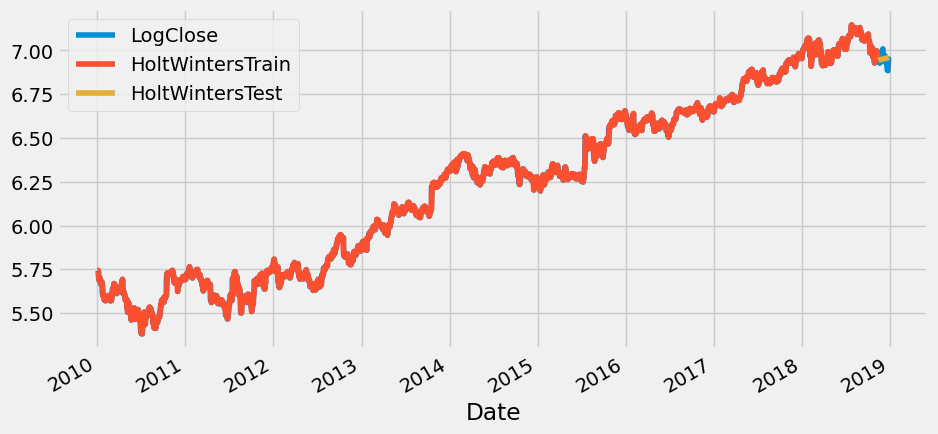

In [12]:
goog.loc[train_idx, "HoltWintersTrain"] = res_hw.fittedvalues
goog.loc[test_idx, "HoltWintersTest"] = res_hw.forecast(Ntest).to_numpy()

goog[["LogClose", "HoltWintersTrain", "HoltWintersTest"]].plot(figsize=(10, 5));

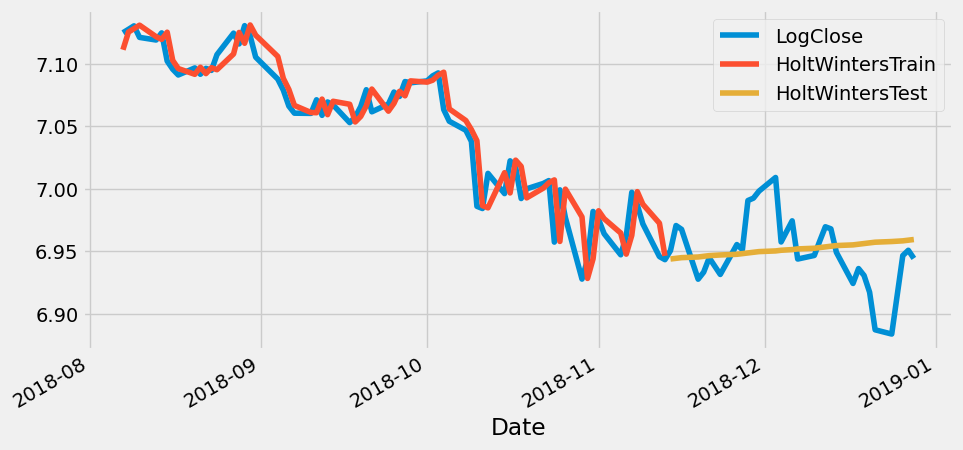

In [13]:
cols = ["LogClose", "HoltWintersTrain", "HoltWintersTest"]
goog.iloc[-100:][cols].plot(figsize=(10, 5));

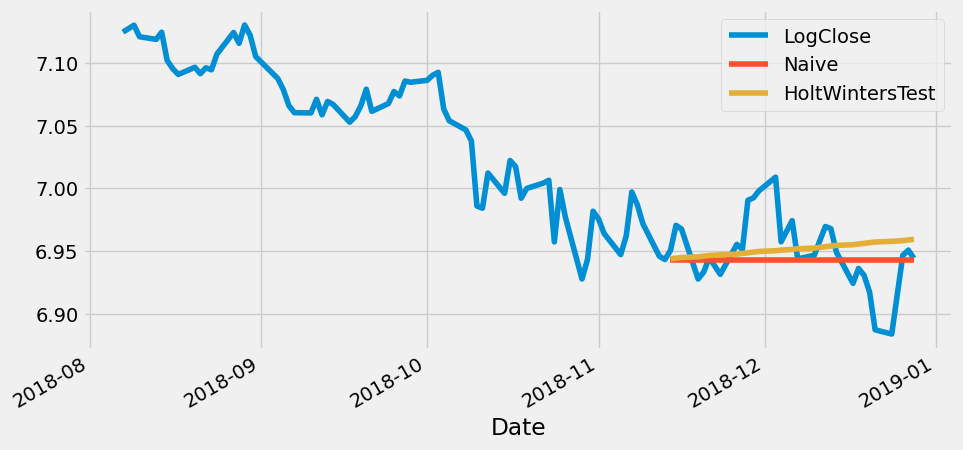

In [14]:
goog.loc[test_idx, "Naive"] = train.iloc[-1]["LogClose"]

goog.iloc[-100:][["LogClose", "Naive", "HoltWintersTest"]].plot(figsize=(10,5));

In [15]:
r2_score(goog.loc[test_idx, "LogClose"], goog.loc[test_idx, "Naive"])

-0.06454209862026317

In [16]:
r2_score(goog.loc[test_idx, "LogClose"], goog.loc[test_idx, "HoltWintersTest"])

-0.15876524787484114